In [1]:
torch.setdefaulttensortype('torch.FloatTensor')
require 'cutorch'

exact = true
separateParams = false
GPUs = {1}

### Load Cityscapes dataset

In [2]:
package.loaded.cityscapes = nil
cityscapes = require 'nyuv2'

cityscapes.relative = '../../Datasets/NYUv2/'
nClasses = cityscapes.nClasses -- 19

trainFiles = cityscapes.loadNames('train')
valFiles = cityscapes.loadNames('val')

In [3]:
require 'cunn'
require 'cudnn'

if #GPUs > 1 then
    local function bnparams(self)
       local p, gp = nn.Module.parameters(self)
        p[#p+1] = self.running_mean
        p[#p+1] = self.running_var
        gp[#gp+1] = self.running_mean:clone():zero()
        gp[#gp+1] = self.running_var:clone():zero()
        return p, gp
    end

    torch.getconstructortable('nn.BatchNormalization').parameters = bnparams
    torch.getconstructortable('cudnn.BatchNormalization').parameters = bnparams
end

cudnn.fastest = true
cudnn.benchmark = true

In [4]:
modelName = '086-enet-int-debugged'
cityscapes.dsize = {560, 424}

### Render labels for displaying

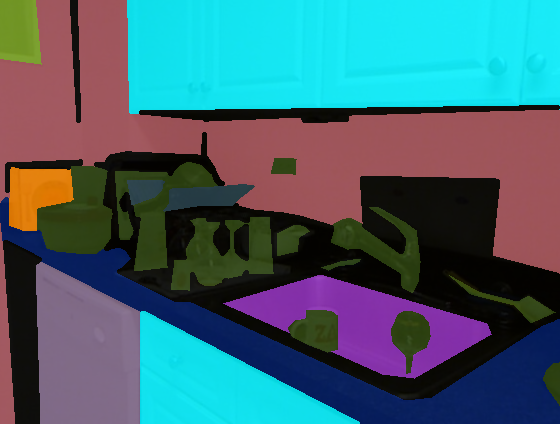

In [5]:
-- example blending
local k = 110
local img, labels = cityscapes.loadSample(trainFiles[k])
itorch.image(cityscapes.renderLabels(labels, img, 0.87))

In [6]:
intKind = 'IntegralSmartNorm'
_G[intKind] = nil
debug.getregistry()[intKind] = nil 
package.loaded[intKind] = nil

require(intKind)

In [7]:
local modelName = modelName
net, GSconfig = 
    assert(loadfile('Models/' .. modelName .. '.lua'))(cityscapes.dsize[1], cityscapes.dsize[2], nClasses)

ints = net:findModules(intKind)
for i = 1,#ints do
    ints[i].normalize = true
    ints[i].exact = exact
    ints[i].saveMemoryIntegral = false
end
print('Number of IntegralSmartNorm modules: ' .. #ints)
print('Number of group sparsity regularized modules: ' .. #GSconfig)

net:cuda()
collectgarbage()

Number of IntegralSmartNorm modules: 8	
Number of group sparsity regularized modules: 0	


In [8]:
math.randomseed(666)
torch.manualSeed(666)
if CUDA then cutorch.manualSeed(666) end

if #GPUs > 1 then
    net = nn.DataParallelTable(1, true, true):threads(
        function()
            require 'cudnn'
            require 'IntegralSmartNorm'
        end)
        :cuda():add(net, GPUs)
end

net:reset()

if separateParams then
    params, gradParams = net:parameters()
else
    params, gradParams = net:getParameters()
end

In [9]:
require 'optim'

datasetIdx = 1

if separateParams then
    optimStates = {}

    local intParamsCount = 0

    for i = 1,#params do
        optimStates[i] = {
            learningRate = 1e-3,
            momentum = 0.9,
            nesterov = true,
            dampening = 0,
            learningRateDecay = 0,
            weightDecay = 2e-4
        }

        for k = 1,#ints do
            if 
                params[i] == ints[k].xMin or
                params[i] == ints[k].xMax or
                params[i] == ints[k].yMin or
                params[i] == ints[k].yMax then

                ints[k].params = ints[k].params or {}
                table.insert(ints[k].params, i)

                optimStates[i].weightDecay = 2e-4 -- 0.0185
                optimStates[i].learningRate = optimStates[i].learningRate
                intParamsCount = intParamsCount + 1
                break
            end
        end

        for k = 1,#GSconfig do
            assert(torch.type(GSconfig[k].haarConv):find('Convolution'))
            assert(torch.type(GSconfig[k].int):find('Integral'))
            assert(torch.type(GSconfig[k].bn):find('SpatialBatchNorm'))

            GSconfig[k].bnMedGamma = 1
            GSconfig[k].bnMedBeta = 0

            if params[i] == GSconfig[k].haarConv.weight then
                optimStates[i].GSconfigIdx = k
    --             optimStates[i].haarConv = haarConvs[k]
    --             optimStates[i].int = assert(ints[k])
    --             optimStates[i].bn = assert(optimStates[i].haarConv.bn)

                -- let us add WD manually
                optimStates[i].weightDecayL2 = optimStates[i].weightDecay
                -- don't let `optim` optimizer do it
                optimStates[i].weightDecay = 0

                optimStates[i].weightDecayGS = 1e-3 -- need to tune
                optimStates[i].groupSparsityTensor = params[i]:clone()
                optimStates[i].tmpSumTensor = params[i].new(params[i]:size(1), 1, 1, 1)
            elseif params[i] == GSconfig[k].bn.weight or params[i] == GSconfig[k].bn.bias then
                GSconfig[k].bn.params = GSconfig[k].bn.params or {}
                table.insert(GSconfig[k].bn.params, i)
            end
        end
    end

    print('Number of IntegralSmartNorm parameter tensors: ' .. intParamsCount)
else
    optimStates = {
        learningRate = 1e-3,
        momentum = 0.9,
        nesterov = true,
        dampening = 0,
        learningRateDecay = 0,
        weightDecay = 2e-4
    }
end

In [10]:
outputDir = 'NYUv2 segmentation/' .. modelName .. '/001/'
os.execute('mkdir "' .. outputDir .. 'Images/train" -p')
os.execute('mkdir "' .. outputDir .. 'Images/val" -p')

In [11]:
-- do return end

for k = 1,#ints do
    for p = 1,ints[k].xMin:nElement() do
        ints[k]:resetSingleWindow(p)
    end
    ints[k].xMin:mul(1.5)
    ints[k].xMax:mul(1.5)
    ints[k].yMin:mul(1.5)
    ints[k].yMax:mul(1.5)
end

In [12]:
package.loaded.WindowDebugger = nil
debug.getregistry().WindowDebugger = nil
WindowDebugger = nil

require 'WindowDebugger'

-- ints = {1,1,1,1,1,1,1,1}
wDebs = (#ints > 0) and {} or nil
for k = 1,#ints do wDebs[k] = WindowDebugger() end

In [13]:
-- Load a saved model
do return end
require 'nngraph'
require 'cunn'
require 'cudnn'

net, optimStates, GSconfig = table.unpack(torch.load(outputDir .. 'net.t7'))
net:cuda()
ints = net:findModules(intKind)
for i = 1,#ints do
    ints[i].normalize = true
    ints[i].exact = exact
end

require 'optim'

loaded = true

if #GPUs > 1 then
    net = nn.DataParallelTable(1, true, true):threads(
        function()
            require 'cudnn'
            require 'IntegralSmartNorm'
        end)
        :cuda():add(net, GPUs)
end

if separateParams then
    params, gradParams = net:parameters()
else
    params, gradParams = net:getParameters()
end

datasetIdx = 1

In [14]:
require 'optim'

onlineLossLogger = optim.Logger(outputDir .. 'onlineLossLog.log')
evalLogger = optim.Logger(outputDir .. 'evalLog.log')
evalAccLogger = optim.Logger(outputDir .. 'evalAccLog.log')

onlineLossLogger:setNames{'Online batch loss'}
evalLogger:setNames{'Train loss', 'Validation loss'}
evalAccLogger:setNames{'Train IoU class', 'Validation IoU class'}

onlineLossLogger:style{'-'}
evalLogger:style{'-', '-'}
evalAccLogger:style{'-', '-', '-', '-'}

onlineLossLogger.showPlot = false
evalLogger.showPlot = false
evalAccLogger.showPlot = false

haarConvLoggers = {}
for k = 1,#GSconfig do
    haarConvLoggers[k] = optim.Logger(outputDir .. 'haarConv' .. k .. 'Log.log')
    local names, styles = {}, {}
    for i = GSconfig[k].l,GSconfig[k].r do
        table.insert(names, tostring(i))
        table.insert(styles, '-')
    end
    haarConvLoggers[k]:setNames(names)
    haarConvLoggers[k]:style(styles)
    haarConvLoggers[k].plotRawCmd = 'unset key'
    haarConvLoggers[k].showPlot = false
end

haarConvZeroCountLogger = optim.Logger(outputDir .. 'haarConvZeroCountLog.log')
local names, styles = {}, {}
for k = 1,#GSconfig do
    table.insert(names, tostring(k))
    table.insert(styles, '-')
end
haarConvZeroCountLogger:setNames(names)
haarConvZeroCountLogger:style(styles)
haarConvZeroCountLogger.showPlot = false

function needToPlot(_onlineLossLogger)
    local plotFreq = 10
    local count = #_onlineLossLogger.symbols[1] + 1
    while count > 1000 do
        plotFreq = plotFreq * 10
        count = count / 10
    end
    
    return #_onlineLossLogger.symbols[1] % plotFreq == 0
end

In [15]:
for k = 1,#ints do
    if wDebs and loaded and paths.filep(outputDir .. 'wd' .. k .. '.t7') then
        wDebs[k]:load(outputDir .. 'wd' .. k .. '.t7')
    end
end

if loaded and paths.filep(outputDir .. 'evalLogger.t7') then
    evalLogger.symbols = torch.load(outputDir .. 'evalLogger.t7')
end
if loaded and paths.filep(outputDir .. 'evalAccLogger.t7') then
    evalAccLogger.symbols = torch.load(outputDir .. 'evalAccLogger.t7')
end
if loaded and paths.filep(outputDir .. 'onlineLossLogger.t7') then
    onlineLossLogger.symbols = torch.load(outputDir .. 'onlineLossLogger.t7')
end

In [16]:
do return end

-- Measure forward/backward propagation time
input = batch --torch.CudaTensor(5, 3, cityscapes.dsize[2], cityscapes.dsize[1]):fill(0.1)
local exactTest = true
net:evaluate()

for k = 1,#ints do
    ints[k].exact = exactTest
end

timer = torch.Timer()
for k = 1,5 do
    net:forward(input)
--     net:backward(input, net.output:clone())
end
cutorch.synchronize()

for k = 1,#ints do
    ints[k].exact = exact
end

print('Average time for 1 forward pass: ' .. (timer:time().real) .. ' seconds. Output size:')
print(net.output:size())

collectgarbage()

In [17]:
criterion = nn.ClassNLLCriterion(cityscapes.classWeights, true, 255):cuda()
-- criterion.nll.ignoreIndex = 255

In [18]:
function predict(net, example)
    local pred = net:forward(nn.utils.addSingletonDimension(example:type(net.modules[1]:type())))
    return select(2, pred[1]:view(cityscapes.dsize[2], cityscapes.dsize[1], nClasses):max(3)):squeeze():float()
end

function comparePredictions(imgIn, labels, prediction, omitOriginal)
    -- tmp buffer for comparePredictions()
    local img = torch.FloatTensor(3, cityscapes.dsize[2], cityscapes.dsize[1])
    img:copy(imgIn)

    img:add(-img:min())
    img:div(img:max())

    local retval

    if omitOriginal then
        retval = torch.ones(3, img:size(2)*2 + 2, img:size(3))

        retval[{{}, {1, img:size(2)}, {}}]:copy(cityscapes.renderLabels(labels, img))
        retval[{{}, {img:size(2)+3, img:size(2)*2+2}, {}}]:copy(cityscapes.renderLabels(prediction, img))
    else
        retval = torch.ones(3, img:size(2)*3 + 4, img:size(3))
        retval[{{}, {1, img:size(2)}, {}}]:copy(img)
        retval[{{}, {img:size(2)+3, img:size(2)*2+2}, {}}]:copy(cityscapes.renderLabels(labels, img, 0.8))
        retval[{{}, {img:size(2)*2+5, retval:size(2)}, {}}]:copy(cityscapes.renderLabels(prediction, img, 0.8))
    end

    collectgarbage()

    return retval
end

In [19]:
evaluationIdxVal = {
    033, 066, 099, 131, 164, 197, 229, 262, 295, 328, 
    360, 393, 426, 458, 491, 524, 556, 589, 622, 654
}

evaluationIdxTrain = {
    001, 040, 080, 120, 160, 200, 240, 280, 320, 360, 
    400, 440, 480, 520, 560, 600, 640, 680, 720, 760,
}

-- table.sort(evaluationIdx)

In [20]:
function evaluate(net, files, indices, outPath)
    local threadLog = {write=function()end, close=function()end, flush=function()end}
    -- local threadLog = io.open(outputDir .. 'threadLog.txt', 'w')
    
    local losses = {}
    local avgLoss = 0
    local confMatrix = torch.LongTensor(cityscapes.nClasses, cityscapes.nClasses):zero()
    
    -- Asynchronous image loading
    threads = require 'threads'
    threads.serialization('threads.sharedserialize')
    threads.Threads.serialization('threads.sharedserialize')
    require 'Queue'
    local queue = Queue() -- a queue of preprocessed input images
    local qMutex = threads.Mutex()
    queue.put = threads.safe(queue.put, qMutex)
    queue.get = threads.safe(queue.get, qMutex)
    local loadNThreads, saveNThreads = 1, 1
    local nJobs = 0 -- number of images that are either in production or not yet consumed
    
    local _dsize, _relative = cityscapes.dsize, cityscapes.relative
    local loadPool = threads.Threads(
        loadNThreads,
        function(threadId)
            (require 'sys').sleep((threadId-1) / 24)
            cityscapes = require 'nyuv2'

            cityscapes.relative = _relative
            cityscapes.dsize = _dsize
            nClasses = cityscapes.nClasses -- 19

            threadFiles = files
        end,

        function(threadId)
--             print('Launching eval load thread #' .. threadId)
        end
    )
    
    local _comparePred = comparePredictions
    local _dsize = cityscapes.dsize
    
    local savePool = outPath and threads.Threads(
        saveNThreads,
        function(threadId)
            (require 'sys').sleep((threadId-1) / 24)
            require 'image'
            cityscapes = require 'nyuv2'
            cityscapes.dsize = _dsize
            
            comparePred = _comparePred
        end,

        function(threadId)
--             print('Launching thread #' .. threadId)
        end
    )
    
    local indicesIdx = 1
    
    for _ = 1,#indices do
        -- add asynchronous image loading tasks
        while indicesIdx <= #indices and nJobs < 10 do
            threadLog:write('Add,nJobs=' .. nJobs .. '\n'); threadLog:flush()
            loadPool:addjob(
                function(nextFileIdx)
                    local input, target =
                        cityscapes.loadSample(threadFiles[nextFileIdx])

                    target = target:view(cityscapes.dsize[1]*cityscapes.dsize[2])

                    collectgarbage()

                    return nextFileIdx, input, target
                end,

                function(nextFileIdx, input, target)
                    queue:put({nextFileIdx, input, target})
                    collectgarbage()
                end,
                
                indices[indicesIdx]
            )
            indicesIdx = indicesIdx + 1
            nJobs = nJobs + 1
        end

        if queue:empty() then
            threadLog:write('Q empty\n'); threadLog:flush()
            loadPool:dojob()
        end

        if queue:empty() then -- should never enter this
            threadLog:write('Q empty again\n'); threadLog:flush()
            os.execute('touch "' .. outputDir .. 'QEMPTY"')
            while queue:empty() do end
        end

        local idx, img, labels = table.unpack(queue:get())
        nJobs = nJobs - 1
        threadLog:write('Consume\n'); threadLog:flush()
        local input = img:cuda()
        local outputs = net:forward(nn.utils.addSingletonDimension(input)):squeeze() -- 13999 x 19
        
        local predictedLabels = 
            select(2, outputs:view(cityscapes.dsize[2], cityscapes.dsize[1], nClasses)
                :max(3)):squeeze():long()
        
        if savePool then
            savePool:addjob(
                function(idx, input, labels, predictedLabels)
                    image.savePNG(
                        outPath .. string.format('/%04d.png', idx), 
                        comparePred(input, labels, predictedLabels))
                    collectgarbage()
                end,
                function() end,
                
                idx, img, labels, predictedLabels
            )
        end
        
        cityscapes.updateConfusionMatrix(confMatrix, predictedLabels, labels)
        
        labels = labels:view(cityscapes.dsize[1]*cityscapes.dsize[2])

        local loss = criterion:forward(outputs, labels:view(-1):cudaByte())
        -- dumb way to find idx
        for i = 1,#indices do
            if indices[i] == idx then
                losses[i] = loss
                break
            end
        end
        avgLoss = avgLoss + loss
    end
    
    local IoUclassAvg = cityscapes.calcIoU(confMatrix)
    
    collectgarbage()
    
    avgLoss = avgLoss / #indices
    
    loadPool:terminate()
    qMutex:free()
    if savePool then
        savePool:terminate()
    end
    threadLog:close()
    
    return avgLoss, IoUclassAvg, losses, confMatrix
end

## Training loop

In [21]:
function augment(img, labels)
    if torch.random() % 2 == 0 then
        img = image.flip(img, 3)
        labels = image.flip(labels, 2)
    else
        labels = labels:clone()
    end

    img = imgPadder:forward(img):clone()
    labels = labelsPadder:forward(nn.utils.addSingletonDimension(labels):float()):byte():squeeze()

    local angle = (math.random() * 2 - 1) * 4.5 / 180 * math.pi
    img = image.rotate(img, angle, 'bilinear')
    labels = image.rotate(labels, angle, 'simple')

    local scale = (math.random() * 2 - 1) * 0.11 + 1.0
    img = image.scale(img, '*'..scale, 'bilinear')
    labels = image.scale(labels, '*'..scale, 'simple')

    local extraH, extraW = img:size(2)-cityscapes.dsize[2], img:size(3)-cityscapes.dsize[1]
    if extraH < 0 or extraW < 0 then
        -- upscale
        img = image.scale(img, cityscapes.dsize[1], cityscapes.dsize[2], 'bilinear')
        labels = image.scale(labels, cityscapes.dsize[1], cityscapes.dsize[2], 'simple')
    else
        -- crop
        local padTop, padLeft = math.floor(extraH / 2), math.floor(extraW / 2)
        local cropH, cropW = {1+padTop,padTop+cityscapes.dsize[2]}, {1+padLeft,padLeft+cityscapes.dsize[1]}
        img = img[{{}, cropH, cropW}]:contiguous()
        labels = labels[{cropH, cropW}]:contiguous()
    end
    
    collectgarbage()
    
    return img, labels
end

In [22]:
function copyConvert(obj, t)
   local copy = {}
   for k, v in pairs(obj) do
      if type(v) == 'table' then
         copy[k] = copyConvert(v, t)
      elseif torch.isTensor(v) then
         copy[k] = v:type(t)
      elseif k == '_type' then
         copy[k] = t
      else
         copy[k] = v
      end
   end
   if torch.typename(obj) then
      torch.setmetatable(copy, torch.typename(obj))
   end
   return copy
end

In [23]:
-- threadLog = io.open(outputDir .. 'threadLog.txt', 'w')
threadLog = {write=function()end, close=function()end, flush=function()end}

batchSize = 2
shuffleEvery = math.ceil(#trainFiles / batchSize) -- shuffle data every `shuffleEvery` iterations
outputFreq = 50 -- how often to output loss to `losses` table and to redraw loss graph
imgOutputFreq = 1 -- save validation predictions as images every `outputFreq*imgOutputFreq` iterations
saveFreq = 1200 -- how often to save `net` and `windowDebugger`s

criticalWeightValue = 0.8e-2

-- Asynchronous image loading
threads = require 'threads'
threads.serialization('threads.sharedserialize')
threads.Threads.serialization('threads.sharedserialize')
require 'Queue'
local queue = Queue() -- a queue of preprocessed input images
local qMutex = threads.Mutex()
queue.put = threads.safe(queue.put, qMutex)
queue.get = threads.safe(queue.get, qMutex)

local nThreads = 5
local nJobs = 0 -- number of images that are either in production or not yet consumed
local timer = torch.Timer()
local _dsize, _relative, _trainFiles, _augment = cityscapes.dsize, cityscapes.relative, trainFiles, augment

local pool = threads.Threads(
    nThreads,
    function(threadId)
        (require 'sys').sleep((threadId-1) / 7)
        require 'image'
        require 'Queue'
        threadTrainFiles = _trainFiles
        cityscapes = require 'nyuv2'
        require 'nn'
        
        torch.setnumthreads(1)

        cityscapes.relative = _relative
        cityscapes.dsize = _dsize
        nClasses = cityscapes.nClasses -- 19
        augment = _augment
        
        imgPadder = nn.SpatialReplicationPadding(
            cityscapes.dsize[1] * 0.2, cityscapes.dsize[1] * 0.2,
            cityscapes.dsize[2] * 0.2, cityscapes.dsize[2] * 0.2):float()
        labelsPadder = imgPadder:clone()
    end,

    function(threadId)
        print('Launching thread #' .. threadId)
    end
)

function randomShuffle(t)
  for i = 1,#t do
    local j = math.random(i, #t)
    t[i], t[j] = t[j], t[i]
  end
end

idx = {}
for i = 1,#trainFiles do
    idx[i] = i
end

local avgLoss = 0

net:training()

collectgarbage()

if not batch or batch:size(1) ~= batchSize then
    batch = torch.CudaTensor(batchSize, 3, cityscapes.dsize[2], cityscapes.dsize[1])
    batchLabels = torch.CudaByteTensor(batchSize, cityscapes.dsize[1]*cityscapes.dsize[2])
    
    batchCPU = cutorch.createCudaHostFloatTensor(batch:size())
    batchLabelsCPU = cutorch.createCudaHostByteTensor(batchLabels:size())
    
    -- for async copy
    cutorch.reserveStreams(1)
    batchR, batchLabelsR = batch:clone(), batchLabels:clone()
end

for _ = 1,24 do
    pool:addjob(
        function(nextFileIdx)
            local img, labels =
                cityscapes.loadSample(threadTrainFiles[nextFileIdx])

            img, labels = augment(img, labels)

            labels[labels:eq(0)] = 255
            labels = labels:view(cityscapes.dsize[1]*cityscapes.dsize[2])

            return img, labels
        end,

        function(img, labels)
            queue:put({img, labels})
        end,

        idx[datasetIdx]
    )
    datasetIdx = datasetIdx % #trainFiles + 1
end

for k = 1,batchSize do      
    pool:dojob()
    pool:addjob(
        function(nextFileIdx)
            local img, labels =
                cityscapes.loadSample(threadTrainFiles[nextFileIdx])

            img, labels = augment(img, labels)

            labels[labels:eq(0)] = 255
            labels = labels:view(cityscapes.dsize[1]*cityscapes.dsize[2])

            return img, labels
        end,

        function(img, labels)
            queue:put({img, labels})
        end,

        idx[datasetIdx]
    )
    datasetIdx = datasetIdx % #trainFiles + 1

    if queue:empty() then -- should never enter this
        threadLog:write('Q empty again\n'); threadLog:flush()
        os.execute('touch "' .. outputDir .. 'QEMPTY"')
        while queue:empty() do end
    end

    local input, target = table.unpack(queue:get())
    nJobs = nJobs - 1
    threadLog:write('Consume\n'); threadLog:flush()

    batchCPU[k]:copy(input)
    batchLabelsCPU[k]:copy(target)
end

batchR:copy(batchCPU)
batchLabelsR:copy(batchLabelsCPU)

-- ************** Main loop ***************

for iter = 1,1e9 do
    
    if (iter-1) % shuffleEvery == 0 then
        randomShuffle(idx)
        print('Epoch ' .. ((iter-1) / shuffleEvery))
    end
    
    if math.max(iter,1) % (18e2*outputFreq) == 0 then
        local optimStatesList = separateParams and optimStates or {optimStates}
        for k = 1,#optimStatesList do
            optimStatesList[k].learningRate = optimStatesList[k].learningRate / 2
            optimStatesList[k].t = 0
            optimStatesList[k].m:zero()
            optimStatesList[k].v:zero()
        end
    end
    
    if wDebs and (iter-1) % 200 == 0 then
        for k = 1,#wDebs do
            wDebs[k]:add(ints[k])
        end
    end
    
    if (iter-1) % saveFreq == 0 then
        torch.save(outputDir .. 'net.t7', 
            {copyConvert(#GPUs > 1 and net:get(1) or net, 'torch.FloatTensor'):clearState(), 
            optimStates, GSconfig})
        
        torch.save(outputDir .. 'evalLogger.t7', evalLogger.symbols)
        torch.save(outputDir .. 'evalAccLogger.t7', evalAccLogger.symbols)
        torch.save(outputDir .. 'onlineLossLogger.t7', onlineLossLogger.symbols)
        
        if wDebs then
            for k = 1,#wDebs do
                wDebs[k]:save(outputDir .. 'wd' .. k .. '.t7')
            end
        end
    end
    
    local batchLoss = 0 -- at current minibatch
    
    -- forward + backward
    do
        threadLog:write('other time: ' .. timer:time().real .. '\n'); threadLog:flush(); timer:reset()
        
        -- start filling 'standby' batch
        cutorch.streamSynchronize(1)
        batch, batchR = batchR, batch
        batchLabels, batchLabelsR = batchLabelsR, batchLabels
        
        threadLog:write('sync time: ' .. timer:time().real .. '\n'); threadLog:flush(); timer:reset()
        
        for k = 1,batchSize do      
            pool:dojob()
            pool:addjob(
                function(nextFileIdx)
                    local img, labels =
                        cityscapes.loadSample(threadTrainFiles[nextFileIdx])

                    img, labels = augment(img, labels)

                    labels[labels:eq(0)] = 255
                    labels = labels:view(cityscapes.dsize[1]*cityscapes.dsize[2])

                    return img, labels
                end,

                function(img, labels)
                    queue:put({img, labels})
                end,

                idx[datasetIdx]
            )
            datasetIdx = datasetIdx % #trainFiles + 1

            if queue:empty() then -- should never enter this
                threadLog:write('Q empty again\n'); threadLog:flush()
                os.execute('touch "' .. outputDir .. 'QEMPTY"')
                while queue:empty() do end
            end

            local input, target = table.unpack(queue:get())
            nJobs = nJobs - 1
            threadLog:write('Consume\n'); threadLog:flush()

            batchCPU[k]:copy(input)
            batchLabelsCPU[k]:copy(target)
        end
        threadLog:write('stby batch fill time: ' .. timer:time().real .. '\n'); threadLog:flush(); timer:reset()
        
        cutorch.setStream(1)
        
        batchR:copyAsync(batchCPU)
        batchLabelsR:copyAsync(batchLabelsCPU)
        
        cutorch.setStream(0)
        
--         print('start fwd')
        threadLog:write('batch transfer time: ' .. timer:time().real .. '\n'); threadLog:flush(); timer:reset()
        local outputs = net:forward(batch) -- 2 x 13999 x 19
        batchLoss = criterion:forward(outputs:view(-1, nClasses), batchLabels:view(-1))
--         print('end fwd')
        net:zeroGradParameters()
--         print('start bwd')
        criterion:backward(outputs:view(-1, nClasses), batchLabels:view(-1))
        collectgarbage()
        net:backward(batch, criterion.gradInput:view(batchSize,-1,nClasses)) -- accumulate gradients
--         print('end bwd')
        
        threadLog:write('fwd+bwd exec time: ' .. timer:time().real .. '\n'); threadLog:flush(); timer:reset()
    end -- do
    
    -- detect NaNs
    function hasNaN(x) return x:ne(x):sum() > 0 end
    if batchLoss ~= batchLoss then -- or hasNaN(net.output) then
        print('Loss is NaN')
        break
    end
    
    onlineLossLogger:add{batchLoss}
    if needToPlot(onlineLossLogger) then onlineLossLogger:plot() end
--     print('start optim')
    -- optimization step
    if separateParams then
        for i = 1,#params do
            local feval = function(x)
                return batchLoss, gradParams[i]
            end
            optim.adam(feval, params[i], optimStates[i])
        end
    else
        local feval = function(x)
            return batchLoss, gradParams
        end
        optim.adam(feval, params, optimStates)
    end
    threadLog:write('opt time: ' .. timer:time().real .. '\n'); threadLog:flush(); timer:reset()
    
    collectgarbage()
    
    if (iter-1) % outputFreq == 0 then
        net:evaluate()
        
        local trainLoss, trainIOUclass = 
            evaluate(net, trainFiles, evaluationIdxTrain,
            ((iter-1) % (outputFreq*imgOutputFreq) == 0) and (outputDir .. 'Images/train/'))
        
        collectgarbage()
        
        local valLoss, valIOUclass = 
            evaluate(net, valFiles, evaluationIdxVal,
            ((iter-1) % (outputFreq*imgOutputFreq) == 0) and (outputDir .. 'Images/val/'))
        
        collectgarbage()
        
        evalLogger:add{trainLoss, valLoss}
        evalLogger:plot()
        evalAccLogger:add{trainIOUclass, valIOUclass}
        evalAccLogger:plot()
        
        net:training()
    end
    
    if lfs.attributes(outputDir .. 'INTERRUPT') then
        os.rename(outputDir .. 'INTERRUPT', outputDir .. 'INTERRUPT_')
        break
    end
end

pool:terminate()
qMutex:free()
threadLog:close()

if wDebs then
    for k = 1,#wDebs do
        wDebs[k]:save(outputDir .. 'wd' .. k .. '.t7')
    end
end

collectgarbage()

Launching thread #1


Launching thread #2


Launching thread #3


Launching thread #4


Launching thread #5


Epoch 0	

In [1]:
local optimStatesList = separateParams and optimStates or {optimStates}
for k = 1,#optimStatesList do
    optimStatesList[k].learningRate = optimStatesList[k].learningRate / 2
    optimStatesList[k].t = 0
    optimStatesList[k].m:zero()
    optimStatesList[k].v:zero()
end

In [ ]:
1e-3 / optimStates.learningRate

In [29]:
-- do this after INTERRUPTing
torch.save(outputDir .. 'net.t7', {copyConvert(#GPUs > 1 and net:get(1) or net, 'torch.FloatTensor'):clearState(), optimStates, GSconfig})

torch.save(outputDir .. 'evalLogger.t7', evalLogger.symbols)
torch.save(outputDir .. 'evalAccLogger.t7', evalAccLogger.symbols)
torch.save(outputDir .. 'onlineLossLogger.t7', onlineLossLogger.symbols)

if wDebs then
    for k = 1,#wDebs do
        wDebs[k]:exportVideo(outputDir .. 'int-layer-' .. k .. '.avi')
    end
end

## Export images for evaluation by `cityscapesScripts`

In [1]:
net:evaluate()
print(net.train)

valLoss, valIOUclass, valIOUcategory = evaluate(net, valFiles, evaluationIdxVal)
print(valIOUclass, valIOUcategory)

net:training()

false	


0.54542613362795	0.80003757136209	


In [4]:
net:evaluate()

function getResultFilename(s)
    local slashIdx = s:find('/')
    s = s:sub(slashIdx+1, -1)
    local slashIdx = s:find('/')
    s = s:sub(slashIdx+1, -1)
    local slashIdx = s:find('/')
    return s:sub(slashIdx+1, -16) .. 'result.png'
end

print('Total ' .. #valFiles)

os.execute('mkdir "' .. cityscapes.relative .. 'results" -p')
local input = torch.CudaTensor()

for k = 1,#valFiles do
    if k % 50 == 0 then print(k) end
    
    local img, labels = cityscapes.loadSample(valFiles[k])

    input:resize(img:size())
    input:copy(img)
    local outputs = net:forward(nn.utils.addSingletonDimension(input)):squeeze()
    local outLabels = 
        select(2, outputs:float():view(cityscapes.dsize[2], cityscapes.dsize[1], nClasses)
            :max(3)):squeeze()
    local outLabelsEval = cityscapes.labelsToEval(outLabels)
    
--     itorch.image(outLabelsEval)
    image.savePNG(
        cityscapes.relative .. 'results/' .. getResultFilename(valFiles[k].image), 
        image.scale(outLabelsEval, 2048, 1024, 'simple'))
end

net:training()

Total 500	


50	


100	


150	


200	


250	


300	


350	


400	


450	


500	
